In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir("/content/drive/My Drive/colab/ImageStyleTransfer")

In [3]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
# 设置图片大小为512
imsize = 512 #if torch.cuda.is_available() else 128 # cpu下设置大小为128

loader = transforms.Compose([
    transforms.Resize([imsize, imsize]),  # 调整图片尺寸
    transforms.ToTensor()])    # 把图片转为tensor


def image_loader(image_name):
    image = Image.open(image_name)
    
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


style_img = image_loader("style/denoised_starry.jpg")
content_img = image_loader("content/test.jpg")

print(style_img.size())
print(content_img.size())


assert style_img.size() == content_img.size(), \
    "style尺寸和content尺寸不一致"

torch.Size([1, 3, 512, 512])
torch.Size([1, 3, 512, 512])


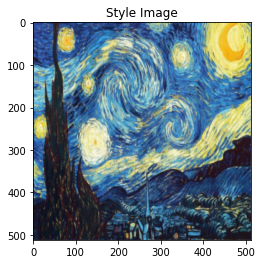

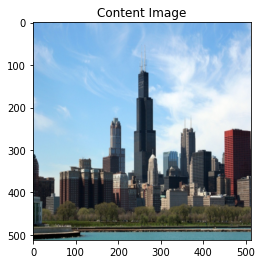

In [6]:
unloader = transforms.ToPILImage()  # 把tensor转为图片

plt.ion()

# 显示图片
def imshow(tensor, title=None):
    image = tensor.cpu().clone()
    image = image.squeeze(0)     
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

In [7]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # 把contentloss接在vgg19的某一层后面，并且detach掉，
        # 因为只用到vgg提取特征，在训练的时候不需要更新vgg的参数
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

In [8]:
def gram_matrix(input):
    # a=batch size
    # b=通道数
    # (c,d)=图片尺寸w，h
    a, b, c, d = input.size()  

    # 把inputresize成二维
    # 行代表 batchsize * 通道数
    # 列代表 图片 w * h
    features = input.view(a * b, c * d) 

    G = torch.mm(features, features.t())  #矩阵想乘
    
    return G.div(a * b * c * d)

In [9]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        # 把styleloss接在vgg19的某一层后面，并且detach掉，
        # 因为只用到vgg提取特征，在训练的时候不需要更新vgg的参数
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        # 计算二张图的特征向量后求gram matrix，再求mean square error
        self.loss = F.mse_loss(G, self.target)
        return input

In [10]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


In [11]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# 标准化
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # 对图片的值标准化，对应tensor的3，4维
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        return (img - self.mean) / self.std


In [12]:
# 从vgg19的conv_4提供内容特征
content_layers_default = ['conv_4']
# 从vgg19的conv_1, conv_2, conv_3, conv_4, conv_5提供风格特征
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)

    
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    
    # 保存loss
    content_losses = []
    style_losses = []
    
    # test
    # mynet = Net().to(device)

    
    # model 用来从vgg中特征并计算损失
    model = nn.Sequential(normalization)

    # model.add_module('my_module', mynet)

    i = 0
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # 在抽取特征时，我们只需要用到VGG从输入层到最靠近输出层的内容层或样式层之间的所有层
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

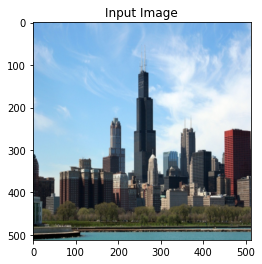

In [13]:
# 显示content图片
input_img = content_img.clone()

plt.figure()
imshow(input_img, title='Input Image')

In [14]:
# 获取优化器
def get_input_optimizer(input_img):
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

In [15]:
# 训练
def run_style_transfer(cnn, normalization_mean, normalization_std, content_img, style_img, input_img, num_steps=300, style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn, normalization_mean, normalization_std, style_img, content_img)
    
    optimizer = get_input_optimizer(input_img)
    
    # optimizer = get_input_optimizer(input_img)
    # mynet = Net().to(device)

    # optimizer = optim.Adam(mynet.parameters())

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # 把值限制在0和1之间
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            # model(input_img)
            model(input_img)
            style_score = 0
            content_score = 0
            
            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss
            
            style_score *= style_weight
            content_score *= content_weight
            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    input_img.data.clamp_(0, 1)

    return input_img


Building the style transfer model..
Optimizing..


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


run [50]:
Style Loss : 177.313202 Content Loss: 28.105061

run [100]:
Style Loss : 61.766609 Content Loss: 26.071135

run [150]:
Style Loss : 23.776108 Content Loss: 23.845785

run [200]:
Style Loss : 10.595922 Content Loss: 21.019985

run [250]:
Style Loss : 6.158116 Content Loss: 18.515484

run [300]:
Style Loss : 4.426779 Content Loss: 16.609421



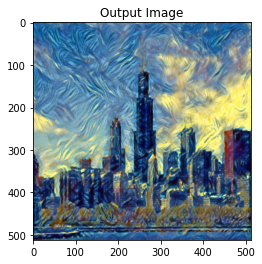

In [16]:
#content + style
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std, content_img, style_img, input_img, num_steps=300)

plt.figure()
imshow(output, title='Output Image')

plt.ioff()
plt.show()

<PIL.Image.Image image mode=RGB size=512x512 at 0x7F2F0C1A1B38>


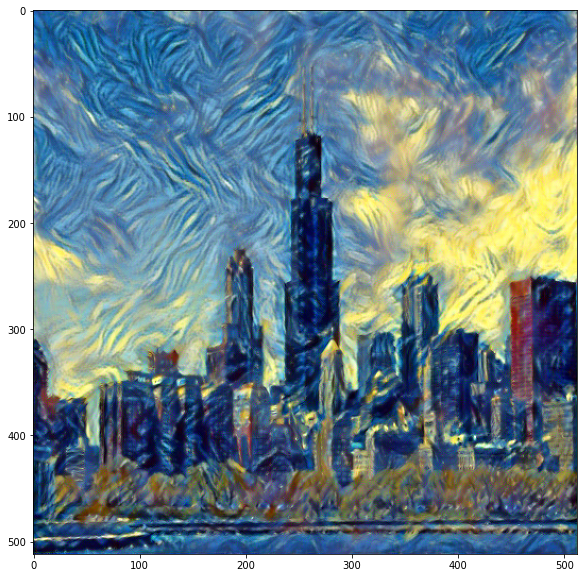

In [17]:
plt.figure(figsize=(10,10))
unloader = transforms.ToPILImage()  # 把tensor转成image

plt.ion()

image = output.cpu().clone()
image = image.squeeze(0)   
image = unloader(image)
plt.imshow(image)
print(image)

plt.show()

